In [2]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """単純なConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 100, 100), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=2, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [3]:
from PIL import Image
import numpy as np
import sys,os

In [4]:
#リストで結果を返す関数
def get_file(dir_path):
    filenames = os.listdir(dir_path)
    return filenames

In [5]:
#画像表示関数(100,100でreshapeして使うこと）
def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()

In [6]:
#写真のパスをそれぞれ指定する
miriteko_jpg = "train/miriteko_train/"
koume_jpg    = "train/koume_train/"
pic_miriteko = get_file(miriteko_jpg)
pic_koume    = get_file(koume_jpg)

In [7]:
#DS_Storeをリストから除外
pic_miriteko.remove('.DS_Store')
pic_koume.remove('.DS_Store')

In [8]:
#リストの確認①
pic_miriteko

['miriteko5.jpg',
 'miriteko4.jpg',
 'miriteko1.jpg',
 'miriteko3.jpg',
 'miriteko2.jpg']

In [9]:
#リストの確認②
pic_koume

['koume7.jpg',
 'koume6.jpg',
 'koume4.jpg',
 'koume5.jpg',
 'koume1.jpg',
 'koume2.jpg',
 'koume3.jpg']

In [10]:
#画像・ラベルを配列に格納する
#松田美里：0、渡邉幸愛：1

datas_pic = []
datas_label = []

#松田美里の画像を配列に格納する
for i in pic_miriteko:
    #写真格納
    #写真をdataに格納する
    data = np.array(Image.open(miriteko_jpg + i).convert("L"), np.float32)
    #画像の形式を(100,100)→(1,100,100)に変更
    data = data.reshape(-1,100,100)
    #画像の次元を追加（axisに指定した成分に次元を追加）
    data_expanded = np.expand_dims(data,axis=0)
    #画像を配列に格納する
    datas_pic.append(data_expanded)
    #Numpy配列に格納する
    train_datas = np.concatenate(datas_pic,axis=0)
    #ラベル格納
    label = 0
    #ラベルの次元を追加する
    label_expanded = np.expand_dims(label,axis=0)
    #ラベルを配列に格納する
    datas_label.append(label_expanded)
    #Numpy配列に格納する
    label_datas = np.concatenate(datas_label,axis=0)
    
#渡邉幸愛の画像を配列に格納する
for i in pic_koume:
    #写真をdataに格納する
    data = np.array(Image.open(koume_jpg + i).convert("L"), np.float32)
    #形式を(100,100)→(1,100,100)に変更
    data = data.reshape(-1,100,100)
    #次元を追加（axisに指定した成分に次元を追加）
    data_expanded = np.expand_dims(data,axis=0)
    #配列に格納する
    datas_pic.append(data_expanded)
    train_datas = np.concatenate(datas_pic,axis=0)
    #ラベル格納
    label = 1
    #ラベルの次元を追加する
    label_expanded = np.expand_dims(label,axis=0)
    #ラベルを配列に格納する
    datas_label.append(label_expanded)
    #Numpy配列に格納する
    label_datas = np.concatenate(datas_label,axis=0)

In [11]:
(x_train,t_train)=(train_datas,label_datas)

In [12]:
(x_test,t_test)=(train_datas,label_datas)

In [13]:
x_train.shape

(12, 1, 100, 100)

In [14]:
label_datas

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [15]:
label_datas.shape

(12,)

In [26]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

In [27]:
# データの読み込み
#(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]


In [28]:
max_epochs = 20

network = SimpleConvNet(input_dim=(1,100,100), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=2, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

train loss:10.63794309563243
=== epoch:1, train acc:0.0, test acc:0.0 ===
train loss:3.5596380530133174
=== epoch:2, train acc:0.0, test acc:0.0 ===
train loss:6.924914129778227
=== epoch:3, train acc:0.0, test acc:0.0 ===
train loss:2.3208783626909817
=== epoch:4, train acc:0.0, test acc:0.0 ===
train loss:0.7889612034562132
=== epoch:5, train acc:0.0, test acc:0.0 ===
train loss:0.5585709279369407
=== epoch:6, train acc:0.0, test acc:0.0 ===
train loss:1.0557896646279112
=== epoch:7, train acc:0.0, test acc:0.0 ===
train loss:0.3057729734659023
=== epoch:8, train acc:0.0, test acc:0.0 ===
train loss:0.384724206323163
=== epoch:9, train acc:0.0, test acc:0.0 ===
train loss:0.579895269879774
=== epoch:10, train acc:0.0, test acc:0.0 ===
train loss:0.3809533415641145
=== epoch:11, train acc:0.0, test acc:0.0 ===
train loss:0.3585120410920032
=== epoch:12, train acc:0.0, test acc:0.0 ===
train loss:0.27298514602156754
=== epoch:13, train acc:0.0, test acc:0.0 ===
train loss:0.42053646325

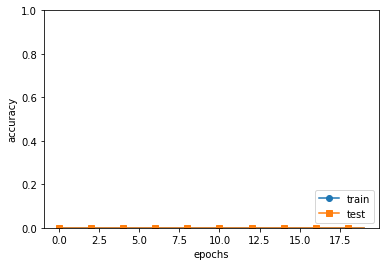

In [34]:
 # グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [4]:
x_train.shape

(60000, 1, 28, 28)

In [7]:
t_train.shape


(60000,)